In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import momlevel
from dask.diagnostics import ProgressBar

In [2]:
data_dir = '/work/jet/sea_level_covariability/data/zarr/'
fname = 'AVISO_global_1994to2020_zos_monthly'
ds = xr.open_zarr(f'{data_dir+fname}',use_cftime=True)

In [3]:
# mean annual cycle -- one value per calendar month
ds = ds.set_coords(['geolon', 'geolat'])
ann_cycle = momlevel.util.annual_cycle(ds.zos)

In [4]:
# amplitude of seasonal cycle
ann_cycle_amplitude = ann_cycle.max('time') - ann_cycle.min('time')
ann_cycle_amplitude = ann_cycle_amplitude.rename('zos_annual_amplitude')

/nbhome/ogrp/python/envs/py311_20240513/lib/python3.11/site-packages/dask/array/reductions.py:621: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


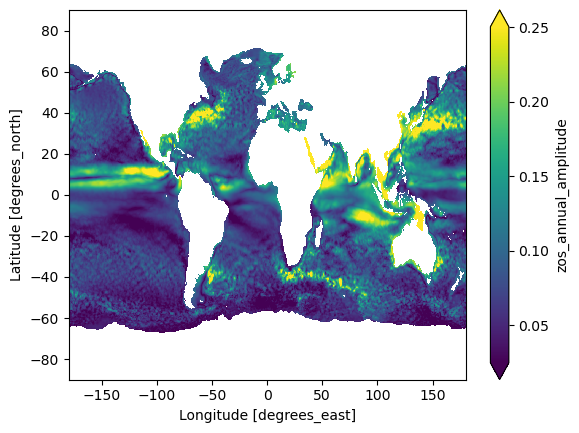

In [5]:
ann_cycle_amplitude.plot(robust=True)

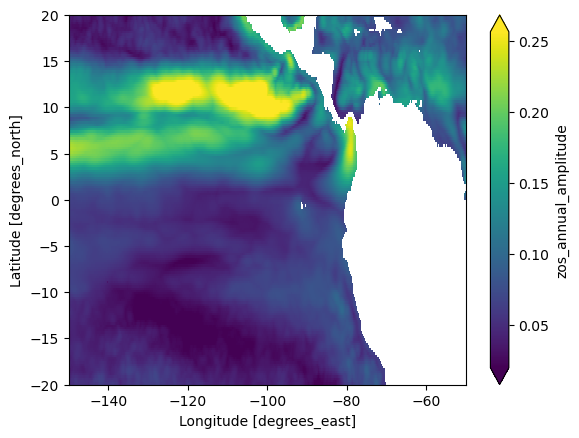

In [6]:
ann_cycle_amplitude.sel(xh=slice(-150,-50),yh=slice(-20,20)).plot(robust=True)

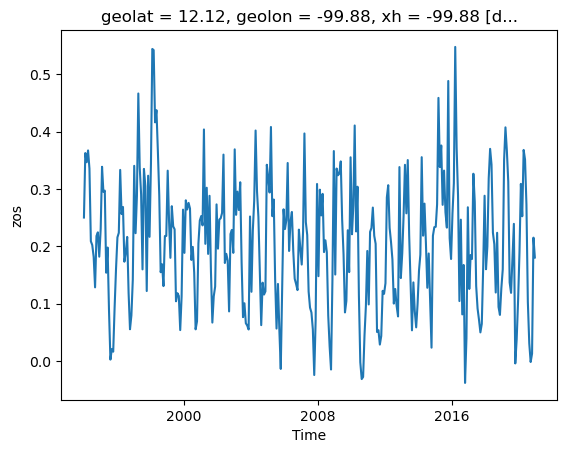

In [7]:
ds.sel({'xh':-100,'yh':12},method='nearest').zos.plot()

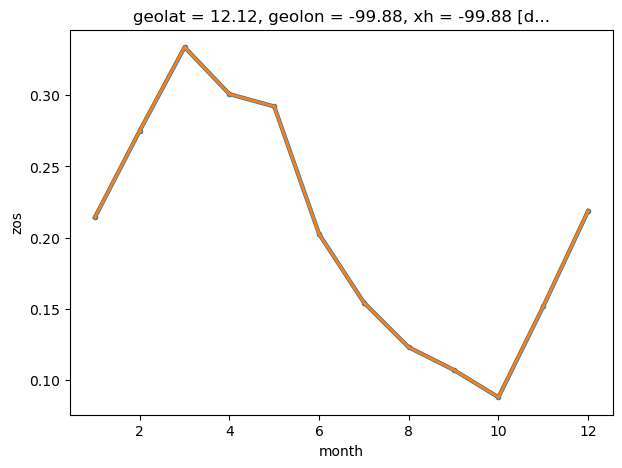

In [8]:
fig, ax = plt.subplots(figsize=(7,5))
ds.zos.groupby('time.month').mean('time').sel({'xh':-100,'yh':12},method='nearest').plot(ax=ax,marker='o',ms=3, lw=3)
ax.plot(ann_cycle.time.dt.month,ann_cycle.sel({'xh':-100,'yh':12},method='nearest'),marker='+',ms=3, lw=2)
plt.show()

### Seasonal model
Function to calculate a seasonal cycle in a time series. This function creates a modelled time series that includes a linear trend and annual and semi-annual harmonics.
```
f(time) = b + m * time + c1 * sin(2*pi*time/year) + …
c2 * cos(2*pi*time/year) + c3 * sin(4*pi*time/year) + … c4 * cos(4*pi*time/year) + residual
```

In [9]:
zos_seasonal_model = momlevel.trend.seasonal_model(ds.zos,return_model=True)

/nbhome/ogrp/python/envs/py311_20240513/lib/python3.11/site-packages/dask/array/einsumfuncs.py:234: PerformanceWarning: Increasing number of chunks by factor of 66
  result = blockwise(
/nbhome/ogrp/python/envs/py311_20240513/lib/python3.11/site-packages/dask/array/core.py:4839: PerformanceWarning: Increasing number of chunks by factor of 66
  result = blockwise(


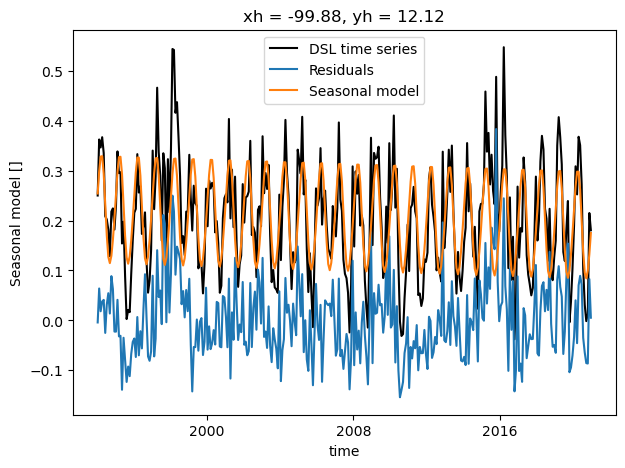

In [10]:
fig, ax = plt.subplots(figsize=(7,5))
ds.sel({'xh':-100,'yh':12},method='nearest').zos.plot(ax=ax,c='k',label='DSL time series')
zos_seasonal_model[1].sel({'xh':-100,'yh':12},method='nearest').plot(ax=ax,label='Residuals')
zos_seasonal_model[0].sel({'xh':-100,'yh':12},method='nearest').plot(ax=ax,label='Seasonal model')
ax.legend()
plt.show()

The `trend.seasonal_model` function in `momlevel` fits a seasonal model (orange line) and allows you to remove seasonality from the whole data array at once. The residuals (blue line) is your deseasonalized time series that can be used to focus on interannual variability.

### Calculate anomlies
One simple way to remove seasonality is to just calculate a mean seasonal cycle. The `groupby` function in xarray allows you to remove this seasonal cycle from the data.

In [11]:
# At each grid point remove the temporal mean and/or seasonal cycle.
da = ds.zos-ds.zos.mean('time')
da_anm = da.groupby('time.month') - da.groupby('time.month').mean('time')

/nbhome/ogrp/python/envs/py311_20240513/lib/python3.11/site-packages/xarray/core/indexing.py:1617: PerformanceWarning: Slicing with an out-of-order index is generating 27 times more chunks
  return self.array[key]


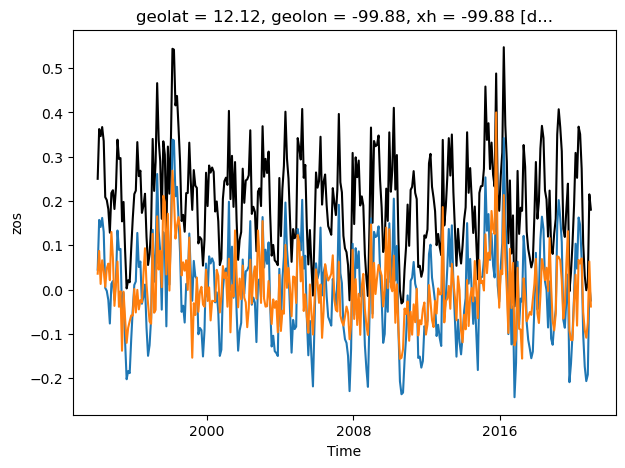

In [12]:
fig, ax = plt.subplots(figsize=(7,5))
ds.sel({'xh':-100,'yh':12},method='nearest').zos.plot(ax=ax,c='k')
da.sel({'xh':-100,'yh':12},method='nearest').plot(ax=ax)
da_anm.sel({'xh':-100,'yh':12},method='nearest').plot(ax=ax)
plt.show()

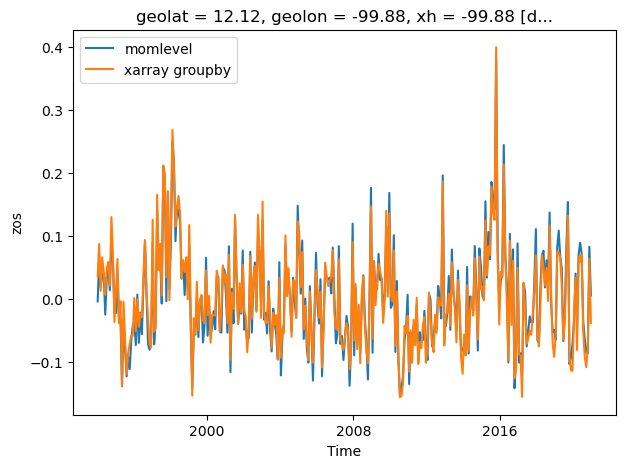

In [13]:
# Compare the two methods:
fig, ax = plt.subplots(figsize=(7,5))
zos_seasonal_model[1].sel({'xh':-100,'yh':12},method='nearest').plot(ax=ax,label='momlevel')
da_anm.sel({'xh':-100,'yh':12},method='nearest').plot(ax=ax,label='xarray groupby')
ax.legend()
plt.show()

### Linear trend

In [14]:
nmonths = xr.DataArray(da.time.dt.days_in_month,coords=[da.time],dims=['time'],name='weights')

In [15]:
da_ann = (da_anm * nmonths).groupby('time.year').sum('time') / nmonths.groupby('time.year').sum('time')

In [16]:
da_lfit = momlevel.trend.calc_linear_trend(da_ann.rename('zos'), dim='year')

In [17]:
with ProgressBar():
    da_trnd = da_lfit.zos_slope.load()

[########################################] | 100% Completed | 36.64 ss


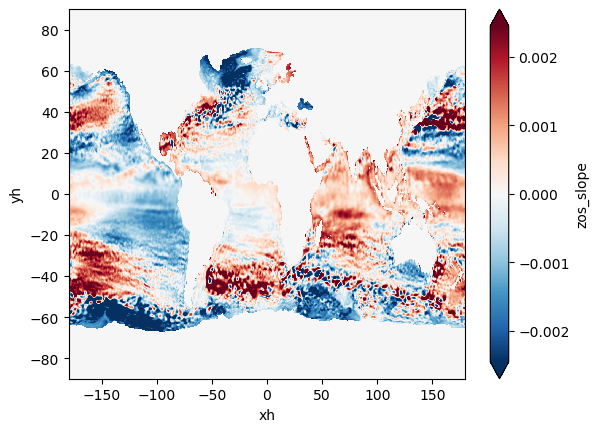

In [18]:
da_trnd.plot(robust=True,cmap='RdBu_r')

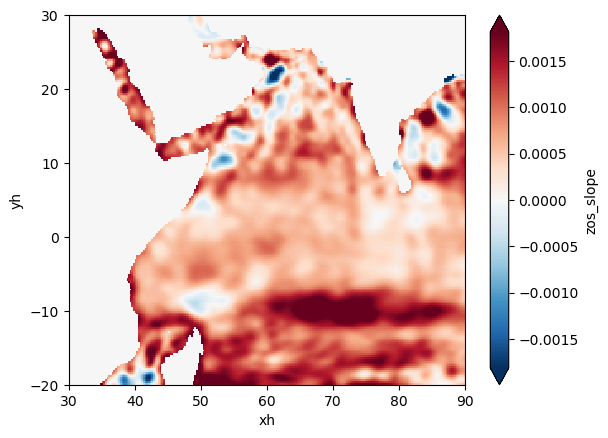

In [19]:
da_trnd.sel(xh=slice(30,90),yh=slice(-20,30)).plot(robust=True)

In [20]:
da_dtr = momlevel.trend.linear_detrend(da_anm)

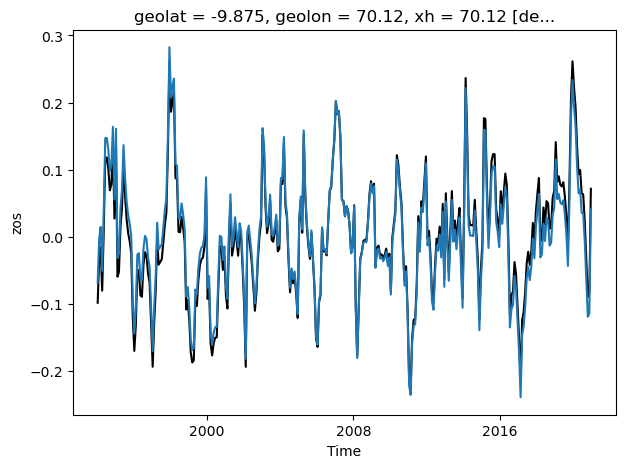

In [21]:
fig, ax = plt.subplots(figsize=(7,5))
da_anm.sel({'xh':70,'yh':-10},method='nearest').plot(ax=ax,c='k')
da_dtr.sel({'xh':70,'yh':-10},method='nearest').plot(ax=ax)
plt.show()

### Temporal distribution (historgram)
Use the detrended and deseasonalized dataset. As an example, plot the temporal distribution for a givem location

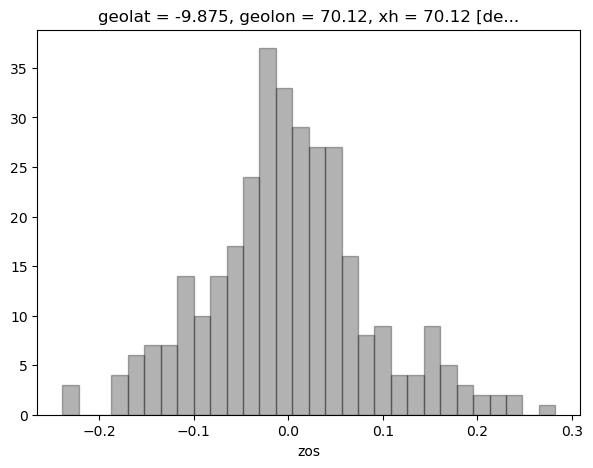

In [22]:
fig, ax = plt.subplots(figsize=(7,5))
da_dtr.sel({'xh':70,'yh':-10},method='nearest').plot.hist(ax=ax, bins=30, alpha=0.3, 
                                                          color='k', edgecolor='k')
plt.show()

One interesting question in sea level variability is to see how Gaussian the temporal distributions are across the global ocean.

## Higher modes of sea level variability

We already looked at the mean and standard deviation of the sea level variability. We can also plot spatial patterns of skewness and kurtosis, giving us additional information about the variability in DSL and it's spatial pattern.

### Skewness
$$ S(\chi) = \frac{\frac{1}{n}\sum_n\chi^3}{(\frac{1}{n}\sum_n\chi^2)^{\frac{3}{2}}} $$

In [23]:
import scipy

In [39]:
zos_skw = da_dtr.reduce(func=scipy.stats.skew,dim='time')
#zos_skw = da_dtr.reduce(np.nanmean, dim='time') / (da_dtr.reduce(np.nanstd, dim='time') ** 3)

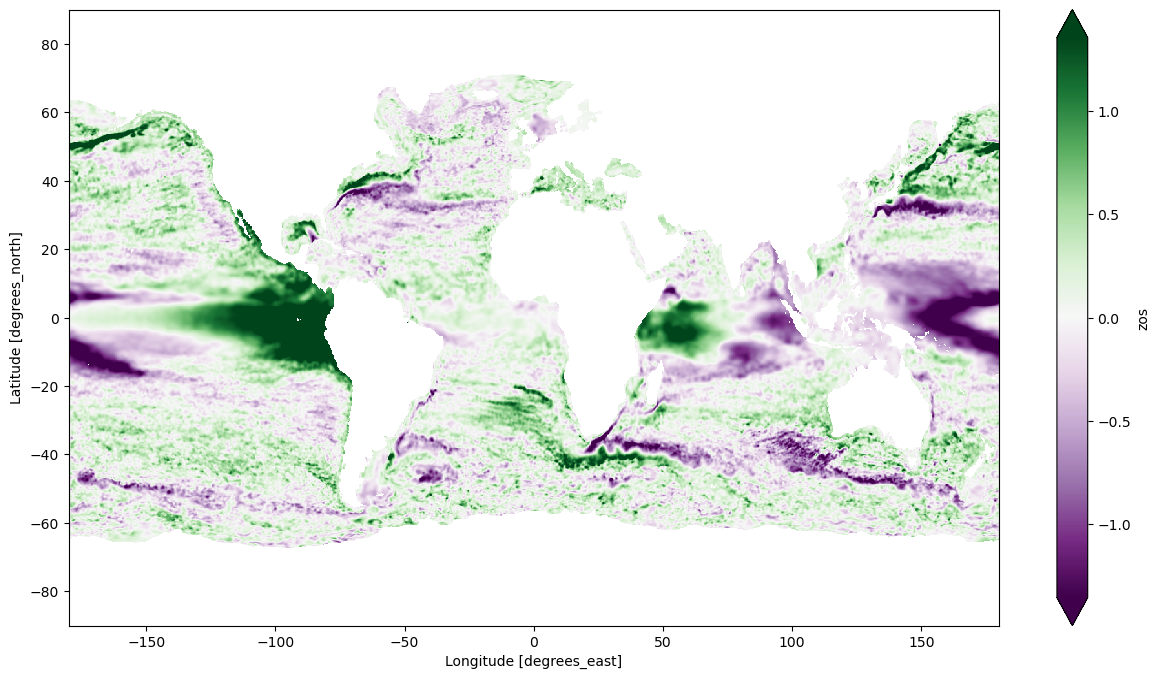

In [40]:
zos_skw.plot(figsize=(15,8),cmap='PRGn',robust=True)

### Kurtosis
**Kurtosis** is a measure of the "tailedness" of the probability distribution. `scipy.stats` computes the kurtosis with *Fisher's definition*, which subtracts 3.0 from the result to give 0.0 for a normal distribution.
$$ K(\chi) = \frac{\frac{1}{n}\sum_n\chi^4}{(\frac{1}{n}\sum_n\chi^2)^2} $$

In [24]:
zos_krt = da_dtr.reduce(func=scipy.stats.kurtosis,dim='time')
#zos_krt = da_dtr.reduce(np.nanmean, dim='time') / (da_dtr.reduce(np.nanstd, dim='time') ** 4)

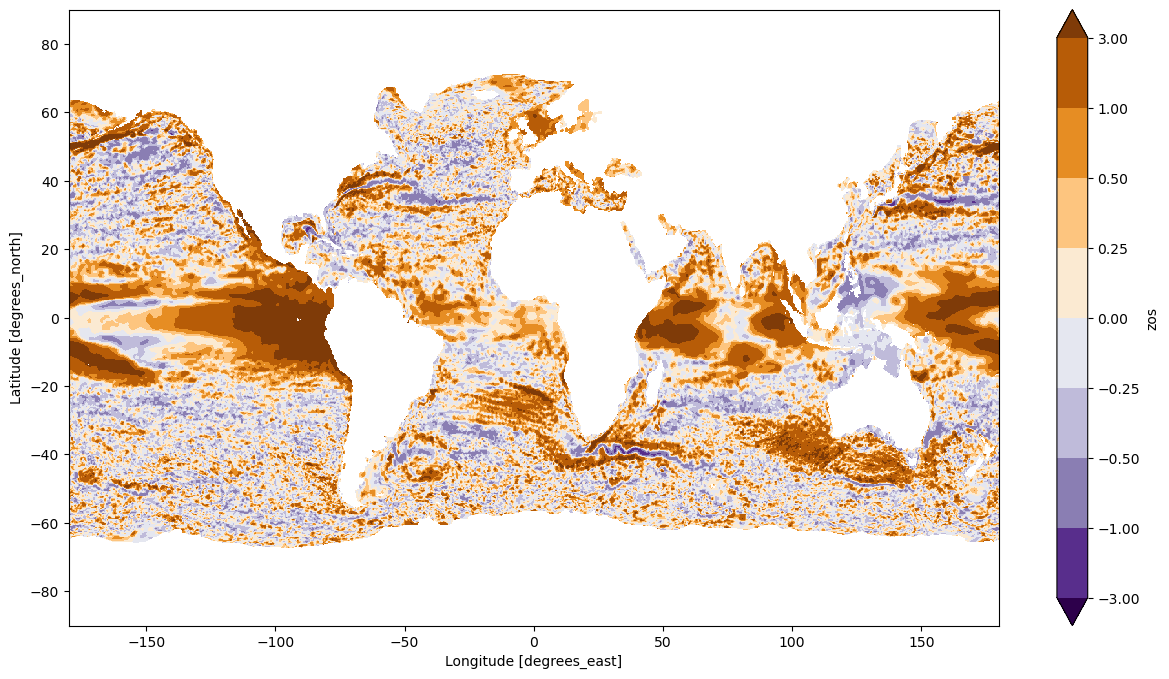

In [25]:
zos_krt.plot(figsize=(15,8),cmap='PuOr_r',levels=[-3,-1,-0.5,-0.25,0,0.25,0.5,1,3],extend='both')